In [1]:
import os
import sys
import time
import shutil
import pandas as pd
import numpy as np
import arcpy
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from CoastalVarExtractor.setvars import *

Does this interpretter allow for string input? y
site: Fisherman
year: 2014
setvars.py initialized variables.


In [2]:
# %% What happens in Arc
# fnamesPts = [f.name for f in arcpy.ListFields(transPts)]
# extTransArr = arcpy.da.FeatureClassToNumPyArray(os.path.join(home,transPts), fnamesPts + ['SHAPE@X','SHAPE@Y'], null_value=fill)
# arr = np.load(os.path.join(out_dir, 'trans_arr_0323.npy'))
# df2 = pd.DataFrame.from_records(arr)

# %% Work with pickled dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))

In [70]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

Transect ID (1-180): 140


In [89]:
# Get data points
dh = pts_set.iloc[0].loc[['DH_x','DH_y','DH_z']]
dl = pts_set.iloc[0].loc[['DL_x','DL_y','DL_z']]
sl = pts_set.iloc[0].loc[['SL_x','SL_y']]
ar = pts_set.iloc[0].loc[['Arm_x','Arm_y','Arm_z']]

dist_dh = pts_set.iloc[0].loc[['DistDH']]
dist_dl = pts_set.iloc[0].loc[['DistDL']]

uBW = pts_set.iloc[0].loc[['uBW']]
uBH = pts_set.iloc[0].loc[['uBH']]
dist_dh

DistDH    87.2355
Name: 25163, dtype: object

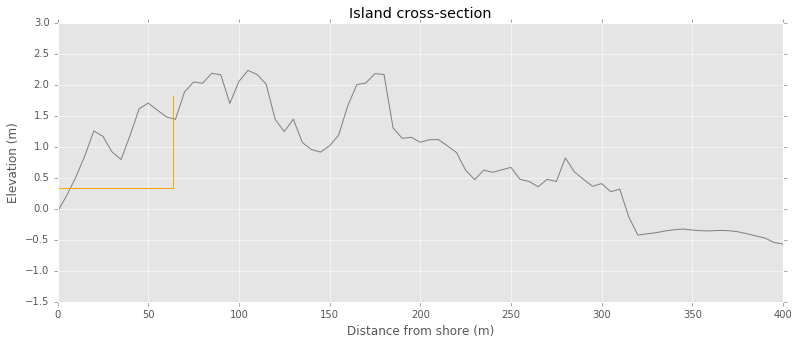

In [90]:
# fig.clear()

fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Island cross-section')

# Plot line
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw'], color='gray', linestyle='-', linewidth = 1)

# Plot points
plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1)
plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1)
plt.plot(dist_dh, dh[2], color='orange', markersize=30)


# plt.annotate('dhi', xy=(dh[0],dh[2]), xytext=(float(dh[0]),float(dh[2])), arrowprops=dict(facecolor='black', shrink=0.05))

# ax.axis('scaled')
ax.set_xlim([0, 400])

# Display plot
plt.show()
plt.close('all')

In [65]:
plt.plot([MHW, uBW],[MHW, MHW], color='c', linestyle='-', linewidth = 1)
plt.plot([uBW, uBW],[MHW, MHW + uBH])
line, = ax.plot([MHW, uBW],[MHW, MHW], color='c', linestyle='-', lw = 1)

In [34]:
 matplotlib.artist.getp(fig)

    agg_filter = None
    alpha = None
    animated = False
    axes = [<matplotlib.axes._subplots.AxesSubplot object at ...
    children = [<matplotlib.patches.Rectangle object at 0x0000000...
    clip_box = None
    clip_on = True
    clip_path = None
    contains = None
    default_bbox_extra_artists = [<matplotlib.axes._subplots.AxesSubplot object at ...
    dpi = 72.0
    edgecolor = (0.5, 0.5, 0.5, 1.0)
    facecolor = (1.0, 1.0, 1.0, 1.0)
    figheight = 5.0
    figure = None
    figwidth = 13.0
    frameon = True
    gid = None
    label = 
    path_effects = []
    picker = None
    rasterized = None
    size_inches = [ 13.   5.]
    sketch_params = None
    snap = None
    tight_layout = False
    transform = IdentityTransform()
    transformed_clip_path_and_affine = (None, None)
    url = None
    visible = True
    window_extent = TransformedBbox(Bbox([[0.0, 0.0], [13.0, 5.0]]), A...
    zorder = 0


In [ ]:
plt.title('Island cross-section')
plt.xlabel('Distance from shore (m)')
plt.ylabel('Elevation (m)')

plt.show()

In [ ]:
plt.title('Island cross-section')
plt.xlabel('Distance from shore (m)')
plt.ylabel('Elevation (m)')

plt.show()

# pts_set.plot()
ax = fig.add_subplot(111)
ax.set_xlabel('Island cross-section (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)

pts_set[['Dist_Seg', 'ptZmhw']].plot()
ax.plot(pts_set['Dist_Seg'], pts_set['ptZmhw'], color='c', linestyle='-', linewidth = 1)


ax.plot(xaxis, pts_set['low-res shl'], color='b', linestyle='--', linewidth = 2, marker='|', markersize=8, markeredgewidth=2)
ax.plot(xaxis, df['high-res shl'], color='b', linestyle='-', linewidth = 2, marker='o', markeredgewidth=0)
ax.plot(xaxis, df['low-res dhi'], color='m', linestyle='--', linewidth = 2, marker='o', markeredgewidth=0)
ax.plot(xaxis, df['high-res dhi'], color='m', linestyle='-', linewidth = 2, marker='o', markeredgewidth=0)
ax.plot(xaxis, df['low-res dlo'], color='k', linestyle='--', linewidth = 2, marker='o', markeredgewidth=0)
ax.plot(xaxis, df['high-res dlo'], color='k', linestyle='-', linewidth = 2, marker='o', markeredgewidth=0)
ax.axis([10, 55, -2, 10]) # range of both axes: [x min, x max, y min, y max]
#ax.axis('equal')
ax.axis('scaled')
plt.show()

fig.clear()